# SpikeInterface DEMO v0.94 -  In2PrimateBrains - May 2022


In this demo, you will use SpikeInterface to analyze a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is kindly provided by [Samuel McKenzie's Lab](https://mckenzieneurolab.com/). 

The objective of this demo is to show all the functionalities of SpikeInterface on a real-world example.

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording. Feel free to use your own recordings as well later on. 

The dataset is called `cambridge_data.dat` and can be found on this [drive link](https://drive.google.com/drive/folders/1eWPuOd8q4MjpVpwazkWygQJDzJnToN3i) (`practice_2_real_dataset` folder). Move the dataset in the current folder.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/home/samuel.garcia/.virtualenvs/py38/lib/python3.8/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import ephyviewer
import spikeinterface_gui as sigui

# %matplotlib widget
%matplotlib inline

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# file path
base_folder = Path('/data_local/DataSpikeSorting/data_tutorial/McKenzie')
recording_file = base_folder / 'cambridge_data.dat'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype = "int16"
time_axis = 0

In [4]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [5]:
recording

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  file_paths: ['/data_local/DataSpikeSorting/data_tutorial/McKenzie/cambridge_data.dat']

We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [6]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [7]:
se.recording_extractor_full_list

[spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 spikeinterface.core.numpyextractors.NumpyRecording,
 spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 spikeinterface.extractors.neoextractors.mearec.MEArecRecordingExtractor,
 spikeinterface.extractors.neoextractors.spikeglx.SpikeGLXRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysLegacyRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor,
 spikeinterface.extractors.neoextractors.intan.IntanRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuroscope.NeuroScopeRecordingExtractor,
 spikeinterface.extractors.neoextractors.plexon.PlexonRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuralynx.NeuralynxRecordingExtractor,
 spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 spikeinterface.extractors.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [8]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


**NEW:** The new SI version supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [9]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [10]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (40000, 64)


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

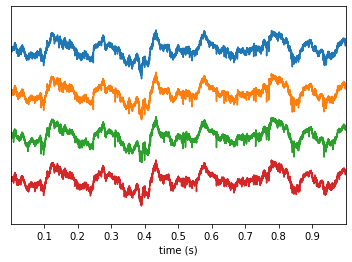

In [11]:
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [12]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

In [13]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch - 4shanks


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [14]:
pi.get_available_pathways()

['H32>RHD2132',
 'ASSY-156>RHD2164',
 'ASSY-77>Adpt.A64-Om32_2x-sm>RHD2164',
 'cambridgeneurotech_mini-amp-64']

In [15]:
probe.wiring_to_device('ASSY-156>RHD2164')

(<matplotlib.collections.PolyCollection at 0x7f48928e8d90>,
 <matplotlib.collections.PolyCollection at 0x7f488f8aa160>)

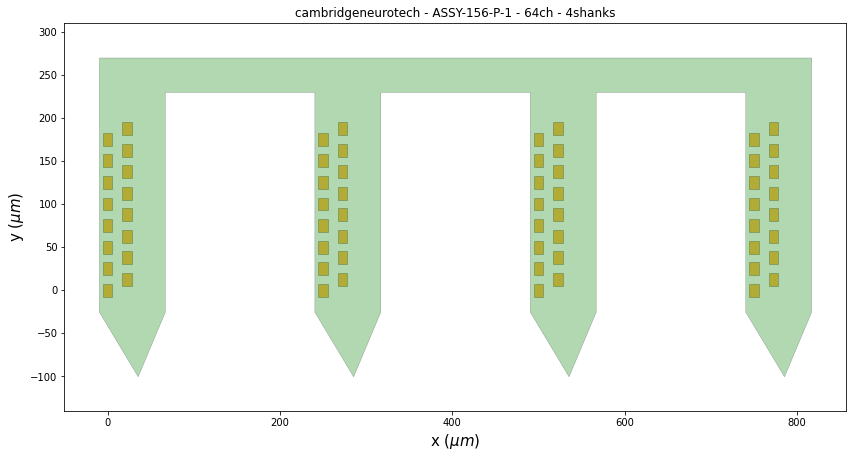

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, ax=ax)


(-50.0, 300.0)

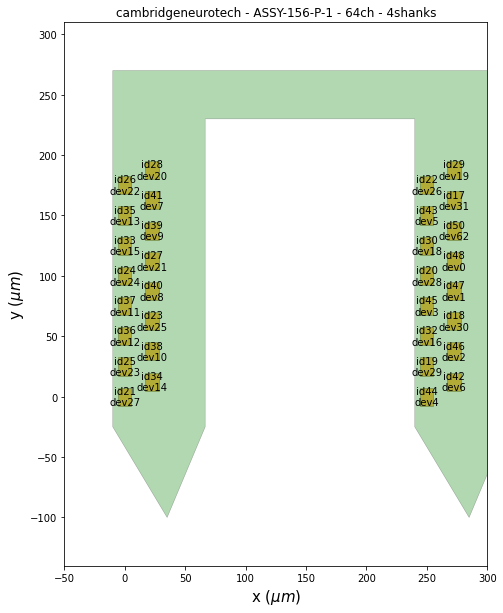

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))
plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)
ax.set_xlim(-50, 300)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [18]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


Note that also the `shank_id` is loaded with the probe.

**NEW:** A `probeinterface` object can be loaded directly to a SI recording object:

In [19]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [20]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,48,1,0
1,47,1,1
2,46,1,2
3,45,1,3
4,44,1,4
...,...,...,...
59,53,2,59
60,52,2,60
61,51,2,61
62,50,1,62


In [21]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [22]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [23]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

In [24]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [25]:
recording_prb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [26]:
recording_prb.set_property(key='quality', values=["good"]*(recording_prb.get_num_channels() - 3),
                           ids=recording_prb.get_channel_ids()[:-3])

In [27]:
recording_prb.get_property("quality")

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', '', '', ''], dtype='<U4')

In [28]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [29]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [30]:
recording_prb.annotate(description="Dataset for SI 0.93 tutorial")

In [31]:
print(recording_prb.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [32]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [33]:
recording_to_process = recordings_by_group[0]

In [34]:
recording_to_process.get_num_channels()

16

Below, we bandpass filter the recording and apply common median reference to the original recording:

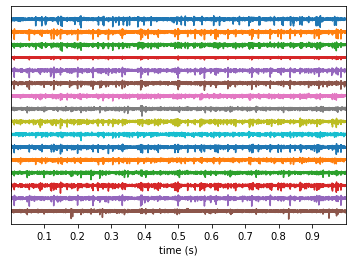

In [35]:
recording_f = st.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

For examplem let's apply Common Median Reference (CMR)

In [36]:
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')
recording_cmr

CommonReferenceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s

We can plot the traces after applying CMR:

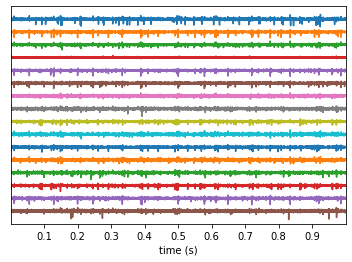

In [37]:
w = sw.plot_timeseries(recording_cmr)

### Use `ephyviewer` to explore the signals

In [ ]:
import ephyviewer
app = ephyviewer.mkQApp()
win = ephyviewer.MainViewer(debug=False, show_auto_scale=True)

In [ ]:
sig_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording)
sig_filtered_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_f)
sig_cmr_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_cmr)

In [ ]:
view1 = ephyviewer.TraceViewer(source=sig_source, name='raw')
view1.params['scale_mode'] = 'same_for_all'
win.add_view(view1)

view2 = ephyviewer.TraceViewer(source=sig_filtered_source, name='filtered')
view2.params['scale_mode'] = 'same_for_all'
win.add_view(view2)

view3 = ephyviewer.TraceViewer(source=sig_filtered_source, name='cmr')
view3.params['scale_mode'] = 'same_for_all'
win.add_view(view3)

In [ ]:
win.show()
app.exec_()

0

## take only 5 min. for demo

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [37]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)
recording_sub

FrameSliceRecording: 16 channels - 1 segments - 20.0kHz - 300.000s

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [38]:
recording_saved = recording_sub.save(folder=base_folder/"preprocessed", progress_bar=True, 
                                     n_jobs=4, total_memory="100M")

write_binary_recording with n_jobs 4  chunk_size 781250


write_binary_recording: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [39]:
recording_saved

BinaryRecordingExtractor: 16 channels - 1 segments - 20.0kHz - 300.000s
  file_paths: ['/data_local/DataSpikeSorting/data_tutorial/McKenzie/preprocessed/traces_cached_seg0.raw']

In [40]:
!ls -ll {base_folder}/preprocessed

total 187572
-rw-rw---- 1 samuel.garcia crnl      5315 mai    3 18:53 cached.json
-rw-rw---- 1 samuel.garcia crnl     10979 mai    3 18:53 probe.json
drwxrwx--- 2 samuel.garcia crnl      4096 mai    3 18:53 properties
-rw-rw---- 1 samuel.garcia crnl     46753 mai    3 18:52 provenance.json
-rw-rw---- 1 samuel.garcia crnl 192000000 mai    3 18:53 traces_cached_seg0.raw


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [41]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [42]:
recording_loaded = si.load_extractor(base_folder/"preprocessed")

In [43]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after loading: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can double check that the traces are exactly the same as the `recording_saved` that we saved:

Text(0.5, 1.0, 'Loaded')

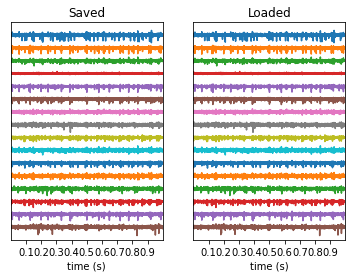

In [44]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use `tridesclous` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if herdingspikes is available. Then we can then check the `tridesclous` default parameters.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [46]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptx238dw6k/script.sh


['herdingspikes', 'pykilosort', 'spykingcircus', 'tridesclous']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [47]:
ss.get_default_params('tridesclous')

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'common_ref_removal': False,
 'nested_params': None,
 'total_memory': '500M',
 'n_jobs_bin': 1}

In [48]:
ss.get_params_description('tridesclous')

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'common_ref_removal': 'remove common reference with median',
 'total_memory': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

In [49]:
ss.run_sorter?

Signature:
ss.run_sorter(
    sorter_name,
    recording,
    output_folder=None,
    remove_existing_folder=True,
    delete_output_folder=False,
    verbose=False,
    raise_error=True,
    docker_image=None,
    singularity_image=None,
    with_output=True,
    **sorter_params,
)
Docstring: <no docstring>
File:      ~/Documents/SpikeInterface/spikeinterface/spikeinterface/sorters/runsorter.py
Type:      function


In [50]:
ss.run_tridesclous?

Signature: ss.run_tridesclous(*args, **kwargs)
Docstring:
Runs tridesclous sorter

Parameters
----------
sorter_name: str
    The sorter name
recording: RecordingExtractor
    The recording extractor to be spike sorted
output_folder: str or Path
    Path to output folder
remove_existing_folder: bool
    If True and output_folder exists yet then delete.
delete_output_folder: bool
    If True, output folder is deleted (default False)
verbose: bool
    If True, output is verbose
raise_error: bool
    If True, an error is raised if spike sorting fails (default).
    If False, the process continues and the error is logged in the log file.
docker_image: None or str
    If str run the sorter inside a container (docker) using the docker package.
**sorter_params: keyword args
    Spike sorter specific arguments (they can be retrieved with 'get_default_params(sorter_name_or_class)'

Returns
-------
sortingextractor: SortingExtractor
    The spike sorted data
File:      ~/Documents/SpikeInterface

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

In [51]:
# run spike sorting on entire recording
sorting_TDC = ss.run_sorter('tridesclous', recording_saved, output_folder=base_folder/'results_TDC', verbose=True)


DataIO <id: 139949043231136> 
  workdir: /data_local/DataSpikeSorting/data_tutorial/McKenzie/results_TDC
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
                       

In [52]:
sorting_TDC

TridesclousSortingExtractor: 14 units - 1 segments - 20.0kHz

In [53]:
print('Found', len(sorting_TDC.get_unit_ids()), 'units')

Found 14 units


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [55]:
!ls {base_folder}/results_TDC

channel_group_0  probe.prb		  spikeinterface_params.json
info.json	 spikeinterface_log.json  spikeinterface_recording.json


In [56]:
!cat {base_folder}/results_TDC/spikeinterface_params.json

{
    "sorter_name": "tridesclous",
    "sorter_params": {
        "freq_min": 400.0,
        "freq_max": 5000.0,
        "detect_sign": -1,
        "detect_threshold": 5,
        "common_ref_removal": false,
        "nested_params": null,
        "total_memory": "500M",
        "n_jobs_bin": 1
    }
}

### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [57]:
!git clone https://github.com/flatironinstitute/ironclust

Clonage dans 'ironclust'...
remote: Enumerating objects: 4964, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 4964 (delta 131), reused 152 (delta 97), pack-reused 4775
Réception d'objets: 100% (4964/4964), 83.82 Mio | 10.64 Mio/s, fait.
Résolution des deltas: 100% (3556/3556), fait.
Mise à jour des fichiers: 100% (846/846), fait.


Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [58]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Setting IRONCLUST_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/presentation/2022_rome_spikeinterface/ironclust


Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [59]:
ss.IronClustSorter.ironclust_path

'/home/samuel.garcia/Documents/presentation/2022_rome_spikeinterface/ironclust'

In [60]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: /tmp/tmp_shellscript7ltetkk0/script.sh


['herdingspikes', 'ironclust', 'pykilosort', 'spykingcircus', 'tridesclous']

In [61]:
# run spike sorting by group
sorting_IC = ss.run_sorter('ironclust', recording_saved, 
                              output_folder=base_folder/'results_IC',
                              verbose=True)


RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptcdep_11w/script.sh
Warning! The recording is already filtered, but ironclust filter is enabled
write_binary_recording with n_jobs 1  chunk_size 15625000
channels = 16, timepoints = 6000000, duration = 5.0 minutes
Creating argfile.txt...
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptrxi8t2ju/script.sh
Running ironclust in /data_local/DataSpikeSorting/data_tutorial/McKenzie/results_IC/tmp...
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptd1e19_wp/script.sh
RUNNING SHELL SCRIPT: /data_local/DataSpikeSorting/data_tutorial/McKenzie/results_IC/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2020 The MathWorks, Inc.

              R2020a Update 2 (9.8.0.1380330) 64-bit (glnxa64)

                                May 5, 2020





                            < M A T L A B (R) >

                  Copyright 1984-2020 The MathWorks, Inc.

              R2020a Update 2 (9.8.0.1380330) 64-bit (glnxa64)

           

In [62]:
sorting_IC

MdaSortingExtractor: 26 units - 1 segments - 20.0kHz
  file_path: /data_local/DataSpikeSorting/data_tutorial/McKenzie/results_IC/tmp/firings.mda

In [63]:
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

IronClust found 26 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [64]:
print(f'Ironclust unit ids: {sorting_IC.get_unit_ids()}')

Ironclust unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [65]:
print(f'Spike train of a unit: {sorting_IC.get_unit_spike_train(13)}')

Spike train of a unit: [    369    1369    2509 ... 5998886 5999281 5999321]


We can use `spikewidgets` functions for some quick visualizations:

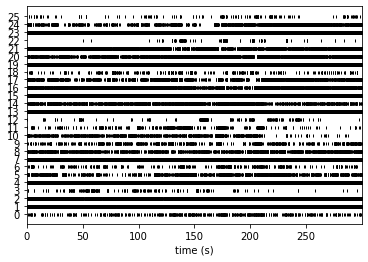

In [66]:
w_rs = sw.plot_rasters(sorting_IC)

# Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [67]:
sorting_outputs = ss.run_sorters(sorter_list=["tridesclous", "ironclust"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder=base_folder / "all_sorters",
                                 verbose=True,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 2})

The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [68]:
print(sorting_outputs.keys())

dict_keys([('group0', 'tridesclous'), ('group0', 'ironclust')])


For the rest of the tutorial, let's pick the `ironclust` output:

In [69]:
sorting_IC = sorting_outputs[('group0', 'ironclust')]
sorting_IC

MdaSortingExtractor: 26 units - 1 segments - 20.0kHz
  file_path: /data_local/DataSpikeSorting/data_tutorial/McKenzie/all_sorters/group0/ironclust/tmp/firings.mda

## Spike sort in Docker containers
###  (Linux and MacOS only)

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

In [70]:
sorting_SC = ss.run_spykingcircus(recording_saved, output_folder="/data_local/DataSpikeSorting/results_SC",
                                  docker_image="spikeinterface/spyking-circus-base:1.0.7", 
                                  verbose=True)

Starting container
Installing spikeinterface from sources in spikeinterface/spyking-circus-base:1.0.7
Running spykingcircus sorter inside spikeinterface/spyking-circus-base:1.0.7
Stopping container


In [71]:
sorting_SC

SpykingCircusSortingExtractor: 39 units - 1 segments - 20.0kHz

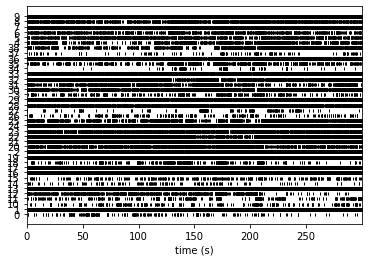

In [72]:
sw.plot_rasters(sorting_SC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

**NEW** In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [73]:
si.extract_waveforms?

Signature:
si.extract_waveforms(
    recording,
    sorting,
    folder,
    load_if_exists=False,
    precompute_template=('average',),
    ms_before=3.0,
    ms_after=4.0,
    max_spikes_per_unit=500,
    unselect_spike_on_border=True,
    overwrite=False,
    return_scaled=True,
    dtype=None,
    use_relative_path=False,
    **job_kwargs,
)
Docstring:
Extracts waveform on paired Recording-Sorting objects.
Waveforms are persistent on disk and cached in memory.

Parameters
----------
recording: Recording
    The recording object
sorting: Sorting
    The sorting object
folder: str or Path
    The folder where waveforms are cached
load_if_exists: bool
    If True and waveforms have already been extracted in the specified folder, they are loaded
    and not recomputed.
precompute_template: None or list
    Precompute average/std/median for template. If None not precompute.
ms_before: float
    Time in ms to cut before spike peak
ms_after: float
    Time in ms to cut after spike peak
ma

In [74]:
we = si.extract_waveforms(recording_saved, sorting_IC, folder=base_folder / "wf_IC", progress_bar=True,
                          n_jobs=4, total_memory="500M", overwrite=False, load_if_exists=True)
print(we)

extract waveforms memmap: 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


WaveformExtractor: 16 channels - 26 units - 1 segments
  before:60 after:80 n_per_units:500


Now all waveforms are computed and stored in the provided `wf_IC` folder. We can now retrieve waveforms and templates easily:

In [75]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (488, 140, 16)
Template shape: (140, 16)
All templates shape: (26, 140, 16)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

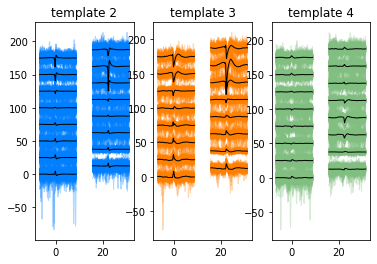

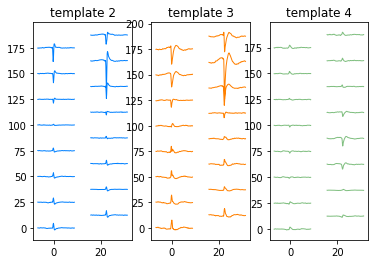

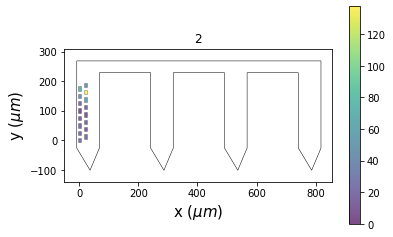

In [76]:
w = sw.plot_unit_waveforms(we, unit_ids=[2, 3, 4])
w = sw.plot_unit_templates(we, unit_ids=[2, 3, 4])
w = sw.plot_unit_probe_map(we, unit_ids=[2,])

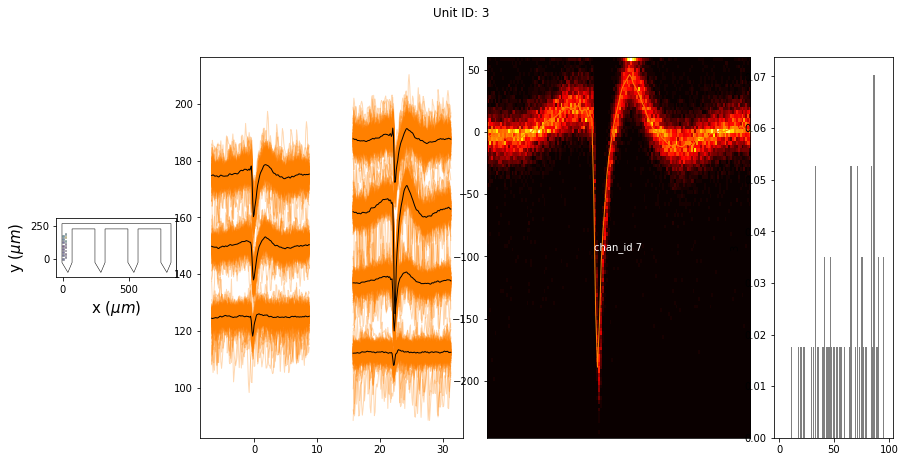

In [78]:
w = sw.plot_unit_summary(we, unit_id=3)

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [79]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 488 - num spikes: 488
Unit 1 - num waveforms: 500 - num spikes: 12849
Unit 2 - num waveforms: 500 - num spikes: 8273
Unit 3 - num waveforms: 236 - num spikes: 236
Unit 4 - num waveforms: 500 - num spikes: 14482
Unit 5 - num waveforms: 499 - num spikes: 1611
Unit 6 - num waveforms: 443 - num spikes: 443
Unit 7 - num waveforms: 500 - num spikes: 7963
Unit 8 - num waveforms: 500 - num spikes: 1577
Unit 9 - num waveforms: 500 - num spikes: 867
Unit 10 - num waveforms: 500 - num spikes: 916
Unit 11 - num waveforms: 500 - num spikes: 595
Unit 12 - num waveforms: 203 - num spikes: 203
Unit 13 - num waveforms: 500 - num spikes: 11095
Unit 14 - num waveforms: 500 - num spikes: 2368
Unit 15 - num waveforms: 500 - num spikes: 19379
Unit 16 - num waveforms: 499 - num spikes: 3174
Unit 17 - num waveforms: 500 - num spikes: 2110
Unit 18 - num waveforms: 412 - num spikes: 412
Unit 19 - num waveforms: 500 - num spikes: 11859
Unit 20 - num waveforms: 500 - num spikes: 3266
Unit 

No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [80]:
we_all = si.extract_waveforms(recording_saved, sorting_IC, folder=base_folder / "wf_IC_all", 
                              max_spikes_per_unit=None, progress_bar=True, load_if_exists=True)

extract waveforms memmap: 100%|##########| 1/1 [00:02<00:00,  2.62s/it]


In [81]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 488 - num spikes: 488
Unit 1 - num waveforms: 12849 - num spikes: 12849
Unit 2 - num waveforms: 8273 - num spikes: 8273
Unit 3 - num waveforms: 236 - num spikes: 236
Unit 4 - num waveforms: 14482 - num spikes: 14482
Unit 5 - num waveforms: 1611 - num spikes: 1611
Unit 6 - num waveforms: 443 - num spikes: 443
Unit 7 - num waveforms: 7963 - num spikes: 7963
Unit 8 - num waveforms: 1577 - num spikes: 1577
Unit 9 - num waveforms: 867 - num spikes: 867
Unit 10 - num waveforms: 916 - num spikes: 916
Unit 11 - num waveforms: 595 - num spikes: 595
Unit 12 - num waveforms: 203 - num spikes: 203
Unit 13 - num waveforms: 11095 - num spikes: 11095
Unit 14 - num waveforms: 2368 - num spikes: 2368
Unit 15 - num waveforms: 19379 - num spikes: 19379
Unit 16 - num waveforms: 3174 - num spikes: 3174
Unit 17 - num waveforms: 2110 - num spikes: 2110
Unit 18 - num waveforms: 412 - num spikes: 412
Unit 19 - num waveforms: 11859 - num spikes: 11859
Unit 20 - num waveforms: 3266 - num 

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `toolkit` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [82]:
st.compute_principal_components?

Signature:
st.compute_principal_components(
    waveform_extractor,
    load_if_exists=False,
    n_components=5,
    mode='by_channel_local',
    whiten=True,
    dtype='float32',
)
Docstring:
Compute PC scores from waveform extractor. The PCA projections are pre-computed only
on the sampled waveforms available from the WaveformExtractor.

Parameters
----------
waveform_extractor: WaveformExtractor
    The waveform extractor
load_if_exists: bool
    If True and pc scores are already in the waveform extractor folders, pc scores are loaded and not recomputed.
n_components: int
    Number of components fo PCA
mode: str
    - 'by_channel_local': a local PCA is fitted for each channel (projection by channel)
    - 'by_channel_global': a global PCA is fitted for all channels (projection by channel)
    - 'concatenated': channels are concatenated and a global PCA is fitted
whiten: bool
    If True, waveforms are pre-whitened
dtype: dtype
    Dtype of the pc scores (default float32)

Returns


In [83]:
pc = st.compute_principal_components(we, n_components=3, load_if_exists=True)

In [85]:
pc0 = pc.get_components(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_components()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (488, 3, 16)
All PC scores shape: (11646, 3, 16)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [86]:
amplitudes = st.compute_spike_amplitudes(we, outputs="concatenated", progress_bar=True)

extract amplitudes: 100%|##########| 1/1 [00:00<00:00,  1.74it/s]


In [87]:
amplitudes

[array([-117.975   , -103.155   ,  -26.714998, ...,  -24.375   ,
        -149.56499 ,  -36.66    ], dtype=float32)]

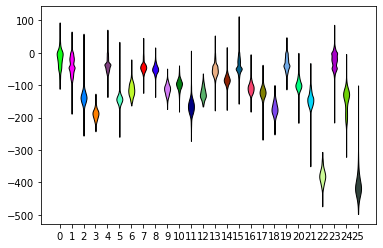

In [88]:
sw.plot_amplitudes_distribution(we)

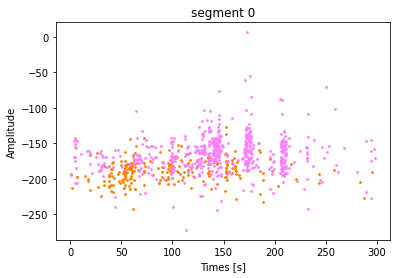

In [89]:
sw.plot_amplitudes_timeseries(we, unit_ids=[3, 11])

By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [90]:
all_spike_times, all_spike_labels = sorting_IC.get_all_spike_trains()[0]

The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [91]:
print(st.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [92]:
template_metrics = st.calculate_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.00092,-0.215728,0.00021,38270.465469,-6474.96097
1,0.00029,-0.112728,0.000145,265470.868455,-139.553477
2,0.000205,-0.329496,0.00014,1359148.498141,-62635.133021
3,0.00084,-0.240657,0.000195,471967.563851,-69172.621832
4,0.000655,-0.241431,0.000205,105261.800797,-11727.923844
5,0.00058,-0.282427,0.000245,417899.129669,-56424.119664
6,0.000585,-0.288771,0.000215,343733.390945,-44630.308035
7,0.00029,-0.244543,0.000145,380066.491146,-15708.490783
8,0.00065,-0.305685,0.000285,144363.123994,-22062.636343
9,0.00066,-0.276173,0.000185,350925.260594,-49411.381986


For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Viewers <a class="anchor" id="viewers"></a>

Let's check put the `spikeinterface-gui` to explore our spike sorting results:

In [93]:
!sigui wf_IC

^C


# 8. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [94]:
print(st.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [95]:
qc = st.compute_quality_metrics(we)

In [96]:
display(qc)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff,isolation_distance,l_ratio,d_prime
0,488,1.626667,0.97,1.271598,0.839828,0.006667,2,0.027881,26.842605,5.827804e+00,1.533508
1,12849,42.830000,1.00,2.719759,0.600254,3.303333,991,0.005335,39.366805,2.329754e+00,1.851862
2,8273,27.576667,1.00,8.279611,0.045293,0.103333,31,0.000518,83.428366,7.142884e-02,5.993015
3,236,0.786667,0.59,13.684422,0.000000,0.000000,0,0.001097,167.039586,2.533894e-05,10.162438
4,14482,48.273333,1.00,3.881724,0.282747,1.976667,593,0.000518,44.705209,1.496716e+00,2.059724
5,1611,5.370000,0.99,14.405005,0.115593,0.010000,3,0.004008,84.027516,5.587969e-02,5.377432
6,443,1.476667,0.85,13.513721,0.000000,0.000000,0,0.061562,71.979882,1.206745e-01,3.249654
7,7963,26.543333,1.00,3.741847,0.252329,0.533333,160,0.009763,47.896012,1.165040e+00,1.881658
8,1577,5.256667,1.00,5.405070,0.361892,0.030000,9,0.000518,55.104229,6.667041e-01,2.258875
9,867,2.890000,0.95,11.098741,0.133034,0.003333,1,0.010404,65.770845,2.839098e-01,4.555427


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

In [97]:
snr_thresh = 5
isi_viol_thresh = 0.2

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [98]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

snr > 5 & isi_violations_rate < 0.2


and then we can use the query to select units:

In [99]:
keep_units = qc.query(our_query)
keep_unit_ids = keep_units.index.values

In [100]:
sorting_auto = sorting_IC.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting_IC.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 26
Number of units after curation: 18


# 8. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

### compare 2 by two

In [107]:
comp = comp_TDC_IC = sc.compare_two_sorters(sorting_TDC, sorting_IC, 'TDC', 'IC')

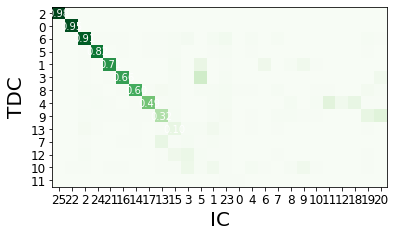

In [108]:
sw.plot_agreement_matrix(comp)

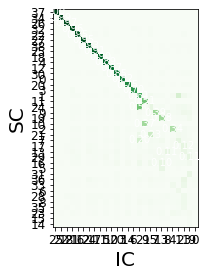

In [109]:
comp = comp_TDC_IC = sc.compare_two_sorters(sorting_SC, sorting_IC, 'SC', 'IC')
sw.plot_agreement_matrix(comp)

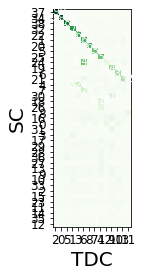

In [110]:
comp = comp_TDC_IC = sc.compare_two_sorters(sorting_SC, sorting_TDC, 'SC', 'TDC')
sw.plot_agreement_matrix(comp)

### compare all

In [111]:
mcmp = sc.compare_multiple_sorters([sorting_TDC, sorting_IC, sorting_SC], ['TDC', 'IC', 'SC'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: TDC and IC
  Comparing: TDC and SC
  Comparing: IC and SC
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


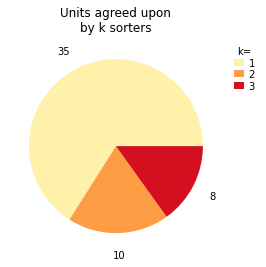

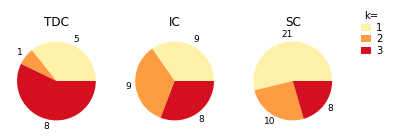

In [112]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

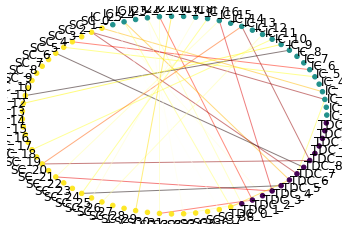

In [113]:
sw.plot_multicomp_graph(mcmp, draw_labels=True)

In [114]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

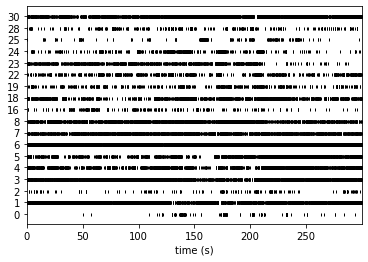

In [115]:
sw.plot_rasters(agreement_sorting)

# 9. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [116]:
from spikeinterface.exporters import export_to_phy

In [122]:
export_to_phy(we_all, output_folder=base_folder / 'phy_IC',
              progress_bar=True, total_memory='100M')

write_binary_recording with n_jobs 1  chunk_size 3125000


extract PCs: 100%|##########| 2/2 [02:02<00:00, 61.20s/it]


Run:
phy template-gui  /data_local/DataSpikeSorting/data_tutorial/McKenzie/phy_IC/params.py


In [123]:
%%capture --no-display
!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [107]:
sorting_IC_phy_curated = se.PhySortingExtractor(base_folder / 'phy_IC/', exclude_cluster_groups=['noise'])

In [108]:
print(f"Number of units before curation: {len(sorting_IC.get_unit_ids())}")
# in manual curation, 4 units were labeled as noise:
print(f"Number of units after curation: {len(sorting_IC_phy_curated.get_unit_ids())}")

Number of units before curation: 25
Number of units after curation: 21


## Export spike sorting report

In [118]:
from spikeinterface.exporters import export_report

In [119]:
%%capture --no-display
export_report(waveform_extractor=we, output_folder=base_folder/"SI_report", format="png", show_figures=False)

In [120]:
!ls {base_folder}/SI_report

 amplitudes_distribution.png   unit_localization.png
'quality metrics.csv'	       units
'unit list.csv'		       units_depth_vs_amplitude.png


In [121]:
!ls {base_folder}/SI_report/units/

0.png	12.png	15.png	18.png	20.png	23.png	2.png  5.png  8.png
10.png	13.png	16.png	19.png	21.png	24.png	3.png  6.png  9.png
11.png	14.png	17.png	1.png	22.png	25.png	4.png  7.png


# Et voilà